Hi, welcome to my (Luke Soko) final project for ABE 516X. There are ~2,000,000 farms across the US, but only ~330 operating manure-based anaerobic digesters. Why? They're historically unprofitable (until recently for specific scenarios). My research models anaerobic digestion profitability. My goal is to publish profitable scenarios for anaerobic digester use to stimulate anaerobic digester implementation and reduce agricultural greenhouse gas emissions. 

One component I must understand is anaerobic digester efficiency. The feedstocks of anaerobic digesters are typically characterized by biochemical methane potential (BMP) which is generally in units of (L CH4/g volatile solids). The BMP value can be considered the best case scenario for gas production, or 100% digestion efficiency. The Livestock Offest Protocol calculator from the California Air Resources Board features BMPs of manure. Using BMPs, the ASAE Manure Production Standard (D384.2), and assuming a 60% CH4 content in biogas, I calculated that a dairy cow produces a maximum of 101.3 ft3 biogas/day and a swine produces a maximum of 5.3 ft3 biogas/day.

EPA AgSTAR has a database featuring number of dairy, swine, and daily biogas production (among other things) for operating anaerobic digesters across the US. I compare the daily biogas production from operating digesters to the hypothetical maximum biogas production to calculate an anaerobic digestion efficiency for different types of anaerobic digesters. I also use the AgSTAR database for machine learning to predict the daily biogas production for inputted number of dairy cows and digester type.

Over 90% of anaerobic digesters are characterized as complete mix, plug flow, or impermeable covered lagoon anaerobic digesters. Therefore, these three types of digesters will be analyzed. 

In [1]:
import pandas as pd

agstar = pd.read_csv("agstar2.csv")

In [2]:
agstar.columns

Index(['Project Name', 'Project Type', 'City', 'County', 'State',
       'Digester Type', 'Status', 'Year Operational', 'Animal/Farm Type(s)',
       'Cattle', 'Dairy', 'Poultry', 'Swine', 'Co-Digestion',
       ' Biogas Generation Estimate (cu_ft/day) ',
       ' Electricity Generated (kWh/yr) ', 'Biogas End Use(s)',
       'System Designer(s)_Developer(s) and Affiliates', 'Receiving Utility',
       ' Total Emission Reductions (MTCO2e/yr) ', 'Awarded USDA Funding?'],
      dtype='object')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import t
nb = MultinomialNB()

In [4]:
def efficiency(data_dairy):
    eff_calc = (data_dairy/101.336)*100
    return  eff_calc

The daily biogas generation is a number that is reported to the EPA by the farm; it is not a calculated number. Digester owners could misreport their daily biogas production, thereby skewing the data. Later, you will see from the histograms that the digester daily biogas per animal distributions are almost all right skewed (a few over-optimistic owners). Therefore, to better analyze the data, I use the two functions below to disclude data that falls outside of 1 or 2 standard deviations.

In [5]:
#95% confidence interval filter for data - 2 standard deviations

def hist_filter_ci(data):
    Y_upper = np.percentile(data['Biogas_ft3/cow'], 97.5)
    Y_lower = np.percentile(data['Biogas_ft3/cow'], 2.5)
    filtered_hist_data = data[(data['Biogas_ft3/cow'] >= Y_lower) & (data['Biogas_ft3/cow'] <= Y_upper)]
    return filtered_hist_data

In [6]:
#68% confidence interval filter for data- 1 standard deviation

def hist_filter_ci_68(data):
    Y_upper = np.percentile(data['Biogas_ft3/cow'], 84)
    Y_lower = np.percentile(data['Biogas_ft3/cow'], 16)
    filtered_hist_data = data[(data['Biogas_ft3/cow'] >= Y_lower) & (data['Biogas_ft3/cow'] <= Y_upper)]
    return filtered_hist_data

In [7]:
df = agstar.copy()

In [8]:
df.fillna(0,inplace=True)

In [9]:
df

,Project Name,Project Type,City,County,State,Digester Type,Status,Year Operational,Animal/Farm Type(s),Cattle,...,Poultry,Swine,Co-Digestion,Biogas Generation Estimate (cu_ft/day),Electricity Generated (kWh/yr),Biogas End Use(s),System Designer(s)_Developer(s) and Affiliates,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?
0,Cargill - Sandy River Farm Digester,Farm Scale,Morrilton,Conway,AR,Covered Lagoon,Operational,2008.0,Swine,0,...,0,"4,200",0,"1,814,400",0,Flared Full-time,Martin Construction Resource LLC (formerly RCM...,0,"4,002",0
1,Butterfield RNG Digester,Farm Scale,Buckeye,Maricopa,AZ,Mixed Plug Flow,Construction,2021.0,Dairy,0,...,0,0,0,0,0,Pipeline Gas,"Avolta [Project Developer]; DVO, Inc. (formerl...",Southwest Gas,"29,826",Y
2,Caballero Dairy Farms Digester,Farm Scale,Eloy,Pinal,AZ,Unknown or Unspecified,Construction,2022.0,Dairy,0,...,0,0,0,0,0,Pipeline Gas,Brightmark [Project Developer],0,"89,518",0
3,Paloma Dairy Digester,Farm Scale,Gila Bend,Maricopa,AZ,Complete Mix,Operational,2021.0,Dairy,0,...,0,0,0,0,0,CNG,Black Bear Environmental Assets [Project Devel...,Southwest Gas Company,"89,794",0
4,Stotz Southern Dairy Digester,Farm Scale,Buckeye,Maricopa,AZ,Covered Lagoon,Operational,2011.0,Dairy,0,...,0,0,0,0,"5,256,000",Electricity,Chapel Street Environmental [System Design Eng...,Arizona Public Service,"138,787",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Norswiss Farms Digester,Farm Scale,Rice Lake,Barron,WI,Complete Mix,Shut down,2006.0,Dairy,0,...,0,0,"Dairy Processing Wastes; Fats, Oils, Greases; ...","2,908,000","6,450,000",Electricity,"Microgy [Project Developer, System Designer]",Dairyland Power Cooperative; Barron Electric,0,Y
502,Quantum Dairy Digester,Farm Scale,Weyauwega,Waupaca,WI,Mixed Plug Flow,Shut down,2005.0,Dairy,0,...,0,0,0,0,"3,350,700",Cogeneration,"DVO, Inc. (formerly GHD, Inc.) [Project Develo...","WE Energies, Inc.",0,Y
503,Stencil Farm Digester,Farm Scale,Denmark,Brown,WI,Horizontal Plug Flow,Shut down,2002.0,Dairy,0,...,0,0,0,0,"946,080",Electricity,Martin Construction Resource LLC (formerly RCM...,Wisconsin Public Service Corporation,0,0
504,Tinedale Farms Digester,Farm Scale,Wrightstown,Jackson,WI,Fixed Film/Attached Media,Shut down,1999.0,Dairy,0,...,0,0,0,"200,000","5,584,500",Electricity; Boiler/Furnace fuel,"AGES [Project Developer, System Designer, Syst...",0,0,0


In [10]:
#remove commas within numbers in dataset then assign numbers the type "integer"

df[' Biogas Generation Estimate (cu_ft/day) ']=df[' Biogas Generation Estimate (cu_ft/day) '].str.replace(',','')
df[' Electricity Generated (kWh/yr) ']=df[' Electricity Generated (kWh/yr) '].str.replace(',','')
df['Dairy']=df['Dairy'].str.replace(',','')
df['Swine']=df['Swine'].str.replace(',','')

In [11]:
#fill na with 0
df.fillna(0,inplace=True)


In [12]:
df = df.astype({' Biogas Generation Estimate (cu_ft/day) ':'int'})
df = df.astype({' Electricity Generated (kWh/yr) ': 'int'})
df = df.astype({'Dairy':'int'})
df = df.astype({'Swine':'int'})

In [13]:
df.head()

,Project Name,Project Type,City,County,State,Digester Type,Status,Year Operational,Animal/Farm Type(s),Cattle,...,Poultry,Swine,Co-Digestion,Biogas Generation Estimate (cu_ft/day),Electricity Generated (kWh/yr),Biogas End Use(s),System Designer(s)_Developer(s) and Affiliates,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?
0,Cargill - Sandy River Farm Digester,Farm Scale,Morrilton,Conway,AR,Covered Lagoon,Operational,2008.0,Swine,0,...,0,4200,0,1814400,0,Flared Full-time,Martin Construction Resource LLC (formerly RCM...,0,"4,002",0
1,Butterfield RNG Digester,Farm Scale,Buckeye,Maricopa,AZ,Mixed Plug Flow,Construction,2021.0,Dairy,0,...,0,0,0,0,0,Pipeline Gas,"Avolta [Project Developer]; DVO, Inc. (formerl...",Southwest Gas,"29,826",Y
2,Caballero Dairy Farms Digester,Farm Scale,Eloy,Pinal,AZ,Unknown or Unspecified,Construction,2022.0,Dairy,0,...,0,0,0,0,0,Pipeline Gas,Brightmark [Project Developer],0,"89,518",0
3,Paloma Dairy Digester,Farm Scale,Gila Bend,Maricopa,AZ,Complete Mix,Operational,2021.0,Dairy,0,...,0,0,0,0,0,CNG,Black Bear Environmental Assets [Project Devel...,Southwest Gas Company,"89,794",0
4,Stotz Southern Dairy Digester,Farm Scale,Buckeye,Maricopa,AZ,Covered Lagoon,Operational,2011.0,Dairy,0,...,0,0,0,0,5256000,Electricity,Chapel Street Environmental [System Design Eng...,Arizona Public Service,"138,787",0


In [14]:
df2 = df.rename(columns={"Animal/Farm Type(s)" : "Animal", "Co-Digestion" : "Codigestion", "Biogas End Use(s)" : "Biogas_End_Use", " Biogas Generation Estimate (cu_ft/day) " : "Biogas_gen_ft3_day"})

In [15]:
df2.columns 

Index(['Project Name', 'Project Type', 'City', 'County', 'State',
       'Digester Type', 'Status', 'Year Operational', 'Animal', 'Cattle',
       'Dairy', 'Poultry', 'Swine', 'Codigestion', 'Biogas_gen_ft3_day',
       ' Electricity Generated (kWh/yr) ', 'Biogas_End_Use',
       'System Designer(s)_Developer(s) and Affiliates', 'Receiving Utility',
       ' Total Emission Reductions (MTCO2e/yr) ', 'Awarded USDA Funding?'],
      dtype='object')

In [16]:
df2

,Project Name,Project Type,City,County,State,Digester Type,Status,Year Operational,Animal,Cattle,...,Poultry,Swine,Codigestion,Biogas_gen_ft3_day,Electricity Generated (kWh/yr),Biogas_End_Use,System Designer(s)_Developer(s) and Affiliates,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?
0,Cargill - Sandy River Farm Digester,Farm Scale,Morrilton,Conway,AR,Covered Lagoon,Operational,2008.0,Swine,0,...,0,4200,0,1814400,0,Flared Full-time,Martin Construction Resource LLC (formerly RCM...,0,"4,002",0
1,Butterfield RNG Digester,Farm Scale,Buckeye,Maricopa,AZ,Mixed Plug Flow,Construction,2021.0,Dairy,0,...,0,0,0,0,0,Pipeline Gas,"Avolta [Project Developer]; DVO, Inc. (formerl...",Southwest Gas,"29,826",Y
2,Caballero Dairy Farms Digester,Farm Scale,Eloy,Pinal,AZ,Unknown or Unspecified,Construction,2022.0,Dairy,0,...,0,0,0,0,0,Pipeline Gas,Brightmark [Project Developer],0,"89,518",0
3,Paloma Dairy Digester,Farm Scale,Gila Bend,Maricopa,AZ,Complete Mix,Operational,2021.0,Dairy,0,...,0,0,0,0,0,CNG,Black Bear Environmental Assets [Project Devel...,Southwest Gas Company,"89,794",0
4,Stotz Southern Dairy Digester,Farm Scale,Buckeye,Maricopa,AZ,Covered Lagoon,Operational,2011.0,Dairy,0,...,0,0,0,0,5256000,Electricity,Chapel Street Environmental [System Design Eng...,Arizona Public Service,"138,787",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Norswiss Farms Digester,Farm Scale,Rice Lake,Barron,WI,Complete Mix,Shut down,2006.0,Dairy,0,...,0,0,"Dairy Processing Wastes; Fats, Oils, Greases; ...",2908000,6450000,Electricity,"Microgy [Project Developer, System Designer]",Dairyland Power Cooperative; Barron Electric,0,Y
502,Quantum Dairy Digester,Farm Scale,Weyauwega,Waupaca,WI,Mixed Plug Flow,Shut down,2005.0,Dairy,0,...,0,0,0,0,3350700,Cogeneration,"DVO, Inc. (formerly GHD, Inc.) [Project Develo...","WE Energies, Inc.",0,Y
503,Stencil Farm Digester,Farm Scale,Denmark,Brown,WI,Horizontal Plug Flow,Shut down,2002.0,Dairy,0,...,0,0,0,0,946080,Electricity,Martin Construction Resource LLC (formerly RCM...,Wisconsin Public Service Corporation,0,0
504,Tinedale Farms Digester,Farm Scale,Wrightstown,Jackson,WI,Fixed Film/Attached Media,Shut down,1999.0,Dairy,0,...,0,0,0,200000,5584500,Electricity; Boiler/Furnace fuel,"AGES [Project Developer, System Designer, Syst...",0,0,0


Throughout the notebook, I drop rows in dataframes for various reasons. Most of the time I'm discluding '0' values or selecting the animal I want to analyze. 

Also, I never want data where there is "codigestion" involved (mutliple feedstocks entering the digester). Typically, codigestion means there is an agricultural residue (corn stover, wheat stalks, brewers grains, etc) added along with manure to the digester. My maximum biogas per animal values, which are used to calculate digester efficiency, are based on a manure-only operating digester.



In [17]:
#Drop unwanted rows from Dataframe

df2.drop(df2[(df2['Animal'] != 'Dairy')].index, inplace = True)
df2.drop(df2[(df2['Codigestion'] != 0)].index, inplace = True)
df2.drop(df2[(df2['Biogas_gen_ft3_day'] == 0)].index, inplace = True)
df2.drop(df2[(df2['Biogas_End_Use'] == 0)].index, inplace = True)

df2['Biogas_ft3/cow'] = df2['Biogas_gen_ft3_day'] / df2['Dairy']

#notwant = ['Electricity', 'Cogeneration; Refrigeration', 'Electricity; CNG',
       #'Boiler/Furnace fuel', 'Electricity; Boiler/Furnace fuel',
       #'Cogeneration', 'Cogeneration; CNG', 'Electricity; Cogeneration',
       #'Flared Full-time', 'Cogeneration; Boiler/Furnace fuel', 'Electricity; Pipeline Gas',
       #'Cogeneration; Pipeline Gas']

#df2 = df2[~df2['Biogas_End_Use'].isin(notwant)]

In [18]:
df2

,Project Name,Project Type,City,County,State,Digester Type,Status,Year Operational,Animal,Cattle,...,Swine,Codigestion,Biogas_gen_ft3_day,Electricity Generated (kWh/yr),Biogas_End_Use,System Designer(s)_Developer(s) and Affiliates,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?,Biogas_ft3/cow
7,ABEC Bidart-Old River LLC Digester,Farm Scale,Bakersfield,Kern,CA,Covered Lagoon,Operational,2013.0,Dairy,0,...,0,0,600000,16206000,Electricity,"4Creeks [System Designer, System Design Engine...",PG&E,"107,483",0,38.709677
8,ABEC Bidart-Stockdale LLC Digester,Farm Scale,Bakersfield,Kern,CA,Covered Lagoon,Operational,2013.0,Dairy,0,...,0,0,50000,4204800,Electricity,"California Bioenergy LLC [Project Developer, S...",PG&E,"14,867",0,29.411765
9,ABEC Carlos Echeverria & Sons Digester,Farm Scale,Bakersfield,Kern,CA,Covered Lagoon,Operational,2018.0,Dairy,0,...,0,0,270000,7600000,Cogeneration; Refrigeration,California Bioenergy LLC [Project Developer]; ...,0,"82,427",0,27.835052
10,ABEC Lakeview Farms Dairy Digester,Multiple Farm/Facility,Bakersfield,Kern,CA,Covered Lagoon,Operational,2018.0,Dairy,0,...,0,0,360000,6700000,Electricity; CNG,California Bioenergy LLC [Project Developer],Pacific Gas and Electric Company,"60,350",0,51.428571
27,Castelanelli Bros. Dairy Digester,Farm Scale,Lodi,San Joaquin,CA,Covered Lagoon,Operational,2004.0,Dairy,0,...,0,0,89148,2233800,Electricity,"Environmental Fabrics, Inc. [Biogas Membrane S...",Pacific Gas and Electric Company,"19,462",Y,27.746032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,Foote Farm Digester,Research,Charlotte,Chittenden,VT,Modular Plug Flow,Shut down,2005.0,Dairy,0,...,0,0,5000,148920,Cogeneration,"Avatar Energy [Project Developer, System Desig...",Green Mountain Power,0,0,31.250000
490,Foster Brothers Farms Digester,Farm Scale,Middlebury,Addison,VT,Horizontal Plug Flow,Shut down,1982.0,Dairy,0,...,0,0,37500,480000,Electricity; Cogeneration,"Hadley and Bennett [System Designer, System De...",0,0,0,98.684211
491,Joneslan Farm Digester,Farm Scale,Hyde Park,Lamoille,VT,Complete Mix,Shut down,2012.0,Dairy,0,...,0,0,33450,223380,Cogeneration,"UEM Group [System Designer, System Design Engi...",Vermont Electric Cooperative,0,0,95.571429
492,Keewaydin Farm Digester,Farm Scale,Stowe,Lamoille,VT,Modular Plug Flow,Shut down,2011.0,Dairy,0,...,0,0,5000,87600,Cogeneration,"Avatar Energy [Project Developer, System Desig...",Stowe Electric,0,0,41.666667


# Data analysis for dairy- all digester types


Dairy farms host the majority of manure-based anaerobic digesters, therefore they have the most/best data for anaerobic digesters. The majority of analysis completed is for dairy anaerobic digesters.

<AxesSubplot:xlabel='Biogas_ft3/cow', ylabel='Count'>

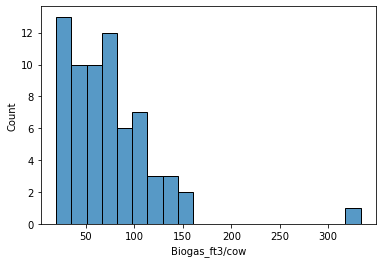

In [19]:
sns.histplot(data = df2['Biogas_ft3/cow'], x=df2['Biogas_ft3/cow'], bins = 20)

In [20]:
df2['Biogas_ft3/cow'].mean()

73.46391320833166

In [21]:
ci95_df2 = hist_filter_ci(df2)

In [22]:
ci95_df2['Biogas_ft3/cow'].mean()

69.73673816020273

NOTE: Any "efficiency" calculation, outputs a value with units %

In [23]:
efficiency(ci95_df2['Biogas_ft3/cow'].mean())

68.8173385176075

In [24]:
ci68_df2  = hist_filter_ci_68(df2)

In [25]:
efficiency(ci68_df2['Biogas_ft3/cow'].mean())

65.78025898722731

In [26]:
dairy_biogas = pd.DataFrame(df2,columns=['Dairy', "Biogas_gen_ft3_day"])

A regression analysis and a 95% confident regression analysis (using  "[0.025 and 0.0975]" OLS Regression Result output) were completed for each digester type. Later, I realized this analysis isn't necessarily helpful for the goal of this particular task. Nonetheless, I left all regressions in this notebook.

In [27]:
dairy_biogas2 = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=dairy_biogas).fit()

print(dairy_biogas2.summary())


                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     112.9
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           7.61e-16
Time:                        16:13:07   Log-Likelihood:                -905.81
No. Observations:                  67   AIC:                             1816.
Df Residuals:                      65   BIC:                             1820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3584.7491   2.89e+04      0.124      0.9

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Dairy', ylabel='Biogas_gen_ft3_day'>

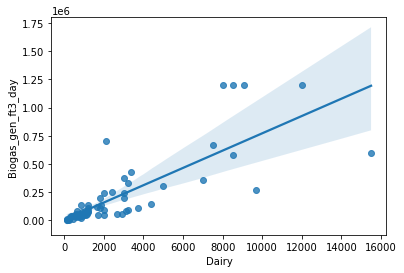

In [28]:
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_biogas, ci =95)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

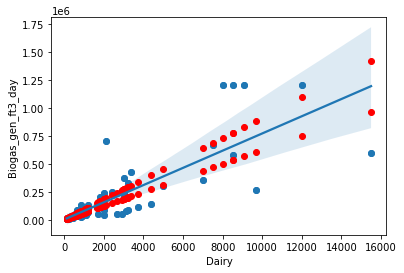

In [29]:
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_biogas, ci = 95)

Y_upper_dairy_biogas = dairy_biogas['Dairy']*91.174+.000614
Y_lower_dairy_biogas = dairy_biogas['Dairy']*62.318-.000542

plt.scatter(dairy_biogas['Dairy'], dairy_biogas['Biogas_gen_ft3_day'])
plt.scatter(dairy_biogas['Dairy'], Y_upper_dairy_biogas, color = 'red')
plt.scatter(dairy_biogas['Dairy'], Y_lower_dairy_biogas, color = 'red')

plt.show

In [30]:
def filter_confidence_interval(data):
    Y_upper = data['Dairy']*91.174+.000614
    Y_lower = data['Dairy']*62.318-.000542
    filtered_data = data[(data['Biogas_gen_ft3_day'] >= Y_lower) & (data['Biogas_gen_ft3_day'] <= Y_upper)]
    return filtered_data


In [31]:
ci95dairy_biogas = filter_confidence_interval(dairy_biogas)

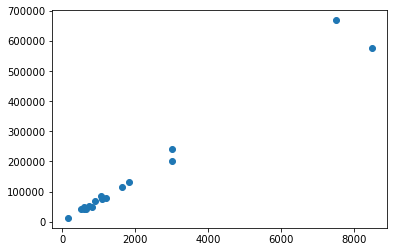

In [32]:
plt.scatter(ci95dairy_biogas['Dairy'], ci95dairy_biogas['Biogas_gen_ft3_day'])

In [33]:
dairy_biogas3 = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=ci95dairy_biogas).fit()

print(dairy_biogas3.summary())

                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     518.7
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           4.77e-13
Time:                        16:13:08   Log-Likelihood:                -199.71
No. Observations:                  17   AIC:                             403.4
Df Residuals:                      15   BIC:                             405.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3956.9715   1.04e+04     -0.381      0.7

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Plug flow digester type analysis for dairy

In [34]:
#Creating dairy plug flow biogas generation

df3 = df.rename(columns={"Animal/Farm Type(s)" : "Animal", "Co-Digestion" : "Codigestion", "Biogas End Use(s)" : "Biogas_End_Use", " Biogas Generation Estimate (cu_ft/day) " : "Biogas_gen_ft3_day"})

In [35]:
df3['Digester Type'].unique()

array(['Covered Lagoon', 'Mixed Plug Flow', 'Unknown or Unspecified',
       'Complete Mix', 'Horizontal Plug Flow', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor',
       'Vertical Plug Flow', 'Complete Mix Mini Digester',
       'Plug Flow - Unspecified', 'Dry Digester', 'Modular Plug Flow',
       'Microdigester'], dtype=object)

In [36]:
df3.drop(df3[(df3['Animal'] != 'Dairy')].index, inplace = True)
df3.drop(df3[(df3['Codigestion'] != 0)].index, inplace = True)
df3.drop(df3[(df3['Biogas_gen_ft3_day'] == 0)].index, inplace = True)
df3['Biogas_ft3/cow'] = df3['Biogas_gen_ft3_day'] / df3['Dairy']

#df3.drop(df3[(df3['Biogas_End_Use'] == 0)].index, inplace = True)

#selecting for 'Vertical Plug Flow', 'Horizontal Plug Flow', and 'Plug Flow - Unspecified', 'Modular Plug Flow', 'Mixed Plug FLow'

notwant = ['Covered Lagoon', 'Unknown or Unspecified',
       'Complete Mix', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor', 'Complete Mix Mini Digester', 'Dry Digester', 
       'Microdigester']

df3 = df3[~df3['Digester Type'].isin(notwant)]

<AxesSubplot:xlabel='Biogas_ft3/cow', ylabel='Count'>

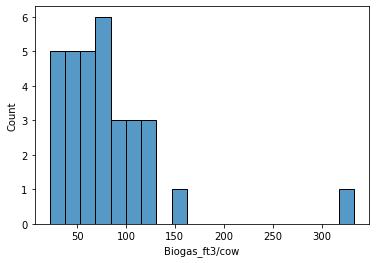

In [37]:
sns.histplot(data = df3['Biogas_ft3/cow'], bins = 20)

In [38]:
ci95_df3 = hist_filter_ci(df3)

In [39]:
ci95_df3['Biogas_ft3/cow'].mean()

74.73078118792917

In [40]:
efficiency(ci95_df3['Biogas_ft3/cow'].mean())

73.74554076333106

In [41]:
ci68_df3  = hist_filter_ci_68(df3)
efficiency(ci68_df3['Biogas_ft3/cow'].mean())

71.27049895301684

In [42]:
df3.shape

(32, 22)

In [43]:
dairy_plugflow = pd.DataFrame(df3,columns=['Dairy', "Biogas_gen_ft3_day"])

                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     105.5
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           2.44e-11
Time:                        16:13:09   Log-Likelihood:                -416.89
No. Observations:                  32   AIC:                             837.8
Df Residuals:                      30   BIC:                             840.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1.38e+04   2.56e+04     -0.538      0.5

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


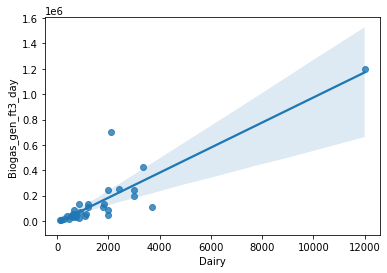

In [44]:
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_plugflow, ci = 95)
dairy_plugsum = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=dairy_plugflow).fit()
print(dairy_plugsum.summary())

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

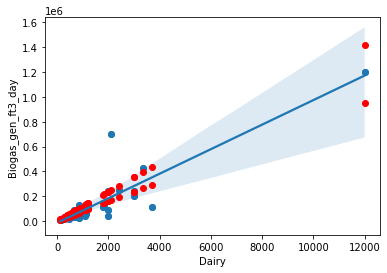

In [45]:
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_plugflow, ci = 95)

Y_upper_dairy_biogas_pf = dairy_plugflow['Dairy']*118.445+.000385
Y_lower_dairy_biogas_pf = dairy_plugflow['Dairy']*79.156-.000661

plt.scatter(dairy_plugflow['Dairy'], dairy_plugflow['Biogas_gen_ft3_day'])
plt.scatter(dairy_plugflow['Dairy'], Y_upper_dairy_biogas_pf, color = 'red')
plt.scatter(dairy_plugflow['Dairy'], Y_lower_dairy_biogas_pf, color = 'red')

plt.show

In [46]:
def filter_confidence_interval_pf(data):
    Y_upper = data['Dairy']*118.445+.000385
    Y_lower = data['Dairy']*79.156-.000661
    filtered_data = data[(data['Biogas_gen_ft3_day'] >= Y_lower) & (data['Biogas_gen_ft3_day'] <= Y_upper)]
    return filtered_data

In [47]:
ci95dairy_biogas_pf = filter_confidence_interval_pf(dairy_plugflow)

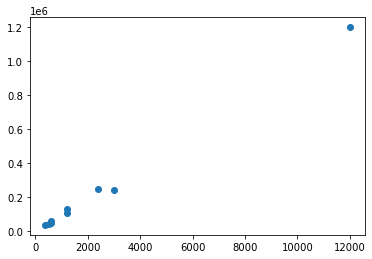

In [48]:
plt.scatter(ci95dairy_biogas_pf['Dairy'], ci95dairy_biogas_pf['Biogas_gen_ft3_day'])

In [49]:
dairy_biogas4 = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=ci95dairy_biogas_pf).fit()

print(dairy_biogas4.summary())

                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2254.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           4.81e-10
Time:                        16:13:09   Log-Likelihood:                -101.65
No. Observations:                   9   AIC:                             207.3
Df Residuals:                       7   BIC:                             207.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7558.4626   8961.461     -0.843      0.4

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Complete mix digester type analysis for dairy

In [50]:
df4 = df.rename(columns={"Animal/Farm Type(s)" : "Animal", "Co-Digestion" : "Codigestion", "Biogas End Use(s)" : "Biogas_End_Use", " Biogas Generation Estimate (cu_ft/day) " : "Biogas_gen_ft3_day"})

In [51]:
df4['Digester Type'].unique()

array(['Covered Lagoon', 'Mixed Plug Flow', 'Unknown or Unspecified',
       'Complete Mix', 'Horizontal Plug Flow', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor',
       'Vertical Plug Flow', 'Complete Mix Mini Digester',
       'Plug Flow - Unspecified', 'Dry Digester', 'Modular Plug Flow',
       'Microdigester'], dtype=object)

In [52]:
df4.drop(df4[(df4['Animal'] != 'Dairy')].index, inplace = True)
df4.drop(df4[(df4['Codigestion'] != 0)].index, inplace = True)
df4.drop(df4[(df4['Biogas_gen_ft3_day'] == 0)].index, inplace = True)
df4['Biogas_ft3/cow'] = df4['Biogas_gen_ft3_day'] / df4['Dairy']


#df4.drop(df4[(df4['Biogas_End_Use'] == 0)].index, inplace = True)

#selecting for 'Complete Mix', 'Complete Mix Mini Digester'

notwant = ['Covered Lagoon', 'Mixed Plug Flow', 'Unknown or Unspecified', 'Horizontal Plug Flow', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor',
       'Vertical Plug Flow','Plug Flow - Unspecified', 'Dry Digester', 'Modular Plug Flow',
       'Microdigester']

df4 = df4[~df4['Digester Type'].isin(notwant)]

In [53]:
df4.shape

(14, 22)

<AxesSubplot:xlabel='Biogas_ft3/cow', ylabel='Count'>

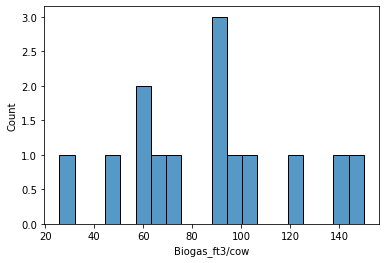

In [54]:
sns.histplot(data = df4['Biogas_ft3/cow'], bins = 20)

In [55]:
ci95_df4 = hist_filter_ci(df4)

ci95_df4['Biogas_ft3/cow'].mean()

87.083266948478

In [56]:
efficiency(ci95_df4['Biogas_ft3/cow'].mean())

85.9351730367076

In [57]:
ci68_df4  = hist_filter_ci_68(df4)
efficiency(ci68_df4['Biogas_ft3/cow'].mean())

82.74672041445051

                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     60.92
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           4.84e-06
Time:                        16:13:10   Log-Likelihood:                -188.22
No. Observations:                  14   AIC:                             380.4
Df Residuals:                      12   BIC:                             381.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.866e+04   6.77e+04     -0.571      0.5

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


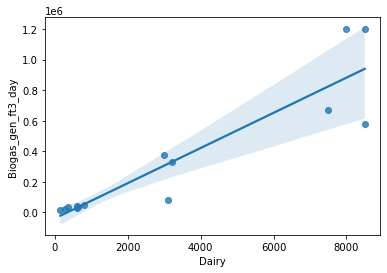

In [58]:
dairy_cm = pd.DataFrame(df4,columns=['Dairy', "Biogas_gen_ft3_day"])
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_cm, ci = 95)
dairy_plugsum = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=dairy_cm).fit()
print(dairy_plugsum.summary())

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

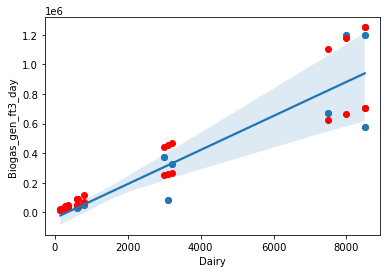

In [59]:
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_cm, ci = 95)

Y_upper_dairy_biogas_cm = dairy_cm['Dairy']*147.165+.00001
Y_lower_dairy_biogas_cm = dairy_cm['Dairy']*82.933 -.0000186

plt.scatter(dairy_cm['Dairy'], dairy_cm['Biogas_gen_ft3_day'])
plt.scatter(dairy_cm['Dairy'], Y_upper_dairy_biogas_cm, color = 'red')
plt.scatter(dairy_cm['Dairy'], Y_lower_dairy_biogas_cm, color = 'red')

plt.show

                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     59.92
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           0.000575
Time:                        16:13:10   Log-Likelihood:                -91.312
No. Observations:                   7   AIC:                             186.6
Df Residuals:                       5   BIC:                             186.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.714e+04   7.15e+04     -0.240      0.8

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


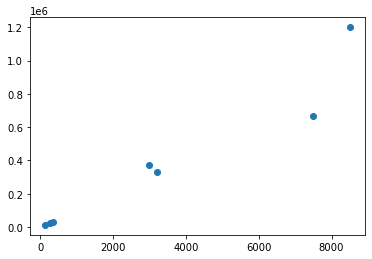

In [60]:
def filter_confidence_interval_cm(data):
    Y_upper = data['Dairy']*147.165+.00001
    Y_lower = data['Dairy']*82.933 -.0000186
    filtered_data = data[(data['Biogas_gen_ft3_day'] >= Y_lower) & (data['Biogas_gen_ft3_day'] <= Y_upper)]
    return filtered_data

ci95dairy_biogas_cm = filter_confidence_interval_cm(dairy_cm)

plt.scatter(ci95dairy_biogas_cm['Dairy'], ci95dairy_biogas_cm['Biogas_gen_ft3_day'])

dairy_biogas5 = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=ci95dairy_biogas_cm).fit()

print(dairy_biogas5.summary())

# Impermeable cover digester type analysis for dairy

In [61]:
df5 = df.rename(columns={"Animal/Farm Type(s)" : "Animal", "Co-Digestion" : "Codigestion", "Biogas End Use(s)" : "Biogas_End_Use", " Biogas Generation Estimate (cu_ft/day) " : "Biogas_gen_ft3_day"})

In [62]:
df5['Digester Type'].unique()

array(['Covered Lagoon', 'Mixed Plug Flow', 'Unknown or Unspecified',
       'Complete Mix', 'Horizontal Plug Flow', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor',
       'Vertical Plug Flow', 'Complete Mix Mini Digester',
       'Plug Flow - Unspecified', 'Dry Digester', 'Modular Plug Flow',
       'Microdigester'], dtype=object)

In [63]:
df5.drop(df5[(df5['Animal'] != 'Dairy')].index, inplace = True)
df5.drop(df5[(df5['Codigestion'] != 0)].index, inplace = True)
df5.drop(df5[(df5['Biogas_gen_ft3_day'] == 0)].index, inplace = True)
df5['Biogas_ft3/cow'] = df5['Biogas_gen_ft3_day'] / df5['Dairy']

#df5.drop(df5[(df5['Biogas_End_Use'] == 0)].index, inplace = True)

#selecting for 'Covered Lagoon'

notwant = ['Mixed Plug Flow', 'Unknown or Unspecified',
       'Complete Mix', 'Horizontal Plug Flow', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor',
       'Vertical Plug Flow', 'Complete Mix Mini Digester',
       'Plug Flow - Unspecified', 'Dry Digester', 'Modular Plug Flow',
       'Microdigester']

df5 = df5[~df5['Digester Type'].isin(notwant)]

<AxesSubplot:xlabel='Biogas_ft3/cow', ylabel='Count'>

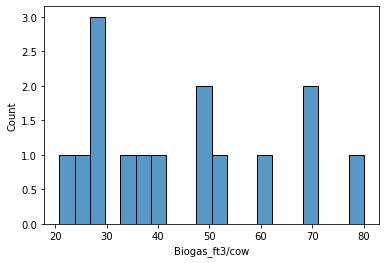

In [64]:
sns.histplot(data = df5['Biogas_ft3/cow'], bins = 20)

In [65]:
ci95_df5 = hist_filter_ci(df5)

ci95_df5['Biogas_ft3/cow'].mean()

43.68490677908262

In [66]:
efficiency(ci95_df5['Biogas_ft3/cow'].mean())

43.108970927491335

In [67]:
ci68_df5  = hist_filter_ci_68(df5)
efficiency(ci68_df5['Biogas_ft3/cow'].mean())

41.088176141031695

In [68]:
df5.shape

(15, 22)

                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           9.46e-08
Time:                        16:13:10   Log-Likelihood:                -183.88
No. Observations:                  15   AIC:                             371.8
Df Residuals:                      13   BIC:                             373.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.424e+04   1.92e+04      0.742      0.4

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


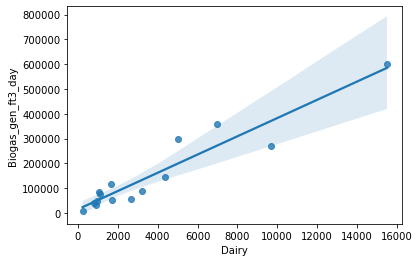

In [69]:
dairy_ic = pd.DataFrame(df5,columns=['Dairy', "Biogas_gen_ft3_day"])
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_ic, ci = 95)
dairy_plugsum = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=dairy_ic).fit()
print(dairy_plugsum.summary())

Impermeable cover anaerobic digesters are not heated. I assumed biogas per dairy would vary significantly per location for impermeable cover digesters. That does not appear to be the case with the below preliminary analysis graph.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Dairy', ylabel='Biogas_gen_ft3_day'>

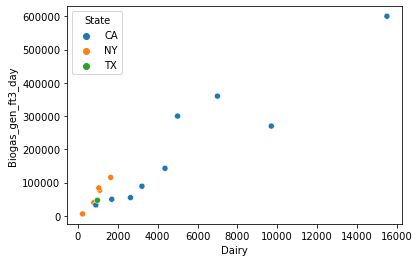

In [70]:
sns.scatterplot('Dairy', 'Biogas_gen_ft3_day', data = df5, hue = 'State')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

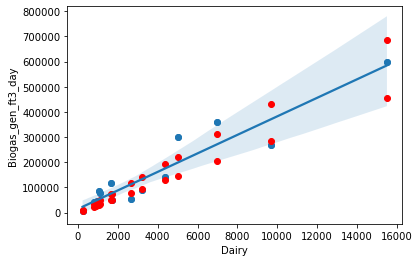

In [71]:
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_ic, ci = 95)

Y_upper_dairy_biogas_ic = dairy_ic['Dairy']*44.35+.000557
Y_lower_dairy_biogas_ic = dairy_ic['Dairy']*29.293 -.000272

plt.scatter(dairy_ic['Dairy'], dairy_ic['Biogas_gen_ft3_day'])
plt.scatter(dairy_ic['Dairy'], Y_upper_dairy_biogas_ic, color = 'red')
plt.scatter(dairy_ic['Dairy'], Y_lower_dairy_biogas_ic, color = 'red')

plt.show


                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1122.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           0.000890
Time:                        16:13:11   Log-Likelihood:                -42.415
No. Observations:                   4   AIC:                             88.83
Df Residuals:                       2   BIC:                             87.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.519e+04   9556.189     -1.590      0.2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


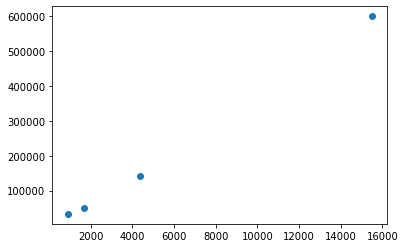

In [72]:
def filter_confidence_interval_ic(data):
    Y_upper = data['Dairy']*44.35+.000557
    Y_lower = data['Dairy']*29.293 -.000272
    filtered_data = data[(data['Biogas_gen_ft3_day'] >= Y_lower) & (data['Biogas_gen_ft3_day'] <= Y_upper)]
    return filtered_data

ci95dairy_biogas_ic = filter_confidence_interval_ic(dairy_ic)

plt.scatter(ci95dairy_biogas_ic['Dairy'], ci95dairy_biogas_ic['Biogas_gen_ft3_day'])

dairy_biogas6 = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=ci95dairy_biogas_ic).fit()

print(dairy_biogas6.summary())

Below is a summary of efficiencies for dairy anaerobic digesters based on the AgSTAR data.

In [73]:
print("Efficiencies of Digesters using 95% CI are:") 
print("For All Dairy") 

print(efficiency(ci95_df2['Biogas_ft3/cow'].mean())) 

print("For plug flow")

print(efficiency(ci95_df3['Biogas_ft3/cow'].mean())) 

print("For complete mix") 

print(efficiency(ci95_df4['Biogas_ft3/cow'].mean())) 

print("For impermeable cover")

print(efficiency(ci95_df5['Biogas_ft3/cow'].mean()))

Efficiencies of Digesters using 95% CI are:
For All Dairy
68.8173385176075
For plug flow
73.74554076333106
For complete mix
85.9351730367076
For impermeable cover
43.108970927491335


In [74]:
print("Efficiencies of Digesters using 68% CI (1 standard deviation) are:") 
print("For All Dairy") 

print(efficiency(ci68_df2['Biogas_ft3/cow'].mean())) 

print("For plug flow")

print(efficiency(ci68_df3['Biogas_ft3/cow'].mean())) 

print("For complete mix") 

print(efficiency(ci68_df4['Biogas_ft3/cow'].mean())) 

print("For impermeable cover")

print(efficiency(ci68_df5['Biogas_ft3/cow'].mean()))

Efficiencies of Digesters using 68% CI (1 standard deviation) are:
For All Dairy
65.78025898722731
For plug flow
71.27049895301684
For complete mix
82.74672041445051
For impermeable cover
41.088176141031695


# Complete mix and plug flow anaerobic digester types for dairy

Complete mix and plug flow anaerobic digesters are heated and impermeable cover anaerobic digesters are not. I analyzed complete mix and plug anaerobic digesters together to calculate an efficiency for heated anaerobic digesters.

In [75]:
df6 = df.rename(columns={"Animal/Farm Type(s)" : "Animal", "Co-Digestion" : "Codigestion", "Biogas End Use(s)" : "Biogas_End_Use", " Biogas Generation Estimate (cu_ft/day) " : "Biogas_gen_ft3_day"})

In [76]:
df6.drop(df6[(df6['Animal'] != 'Dairy')].index, inplace = True)
df6.drop(df6[(df6['Codigestion'] != 0)].index, inplace = True)
df6.drop(df6[(df6['Biogas_gen_ft3_day'] == 0)].index, inplace = True)
df6['Biogas_ft3/cow'] = df6['Biogas_gen_ft3_day'] / df6['Dairy']

#df3.drop(df3[(df3['Biogas_End_Use'] == 0)].index, inplace = True)

#selecting for 'Complete Mix Mini Digester', 'Complete Mix','Vertical Plug Flow', 'Horizontal Plug Flow', and 'Plug Flow - Unspecified', 'Modular Plug Flow', 'Mixed Plug FLow'

notwant = ['Covered Lagoon', 'Unknown or Unspecified', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor', 'Dry Digester', 
       'Microdigester']

df6 = df6[~df6['Digester Type'].isin(notwant)]

<AxesSubplot:xlabel='Biogas_ft3/cow', ylabel='Count'>

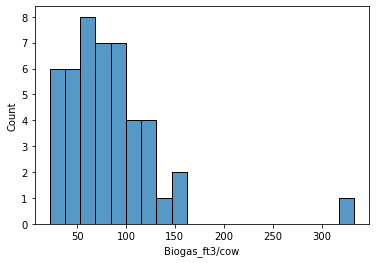

In [77]:
sns.histplot(data = df6['Biogas_ft3/cow'], bins = 20)

In [78]:
ci95_df6 = hist_filter_ci(df6)

In [79]:
ci95_df6['Biogas_ft3/cow'].mean()
efficiency(ci95_df6['Biogas_ft3/cow'].mean())

77.10390425281459

In [80]:
ci68_df6  = hist_filter_ci_68(df6)
efficiency(ci68_df6['Biogas_ft3/cow'].mean())

75.29627474795387

In [81]:
df6.shape

(46, 22)

                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     201.1
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           5.13e-18
Time:                        16:13:11   Log-Likelihood:                -607.56
No. Observations:                  46   AIC:                             1219.
Df Residuals:                      44   BIC:                             1223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.482e+04   2.57e+04     -0.968      0.3

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


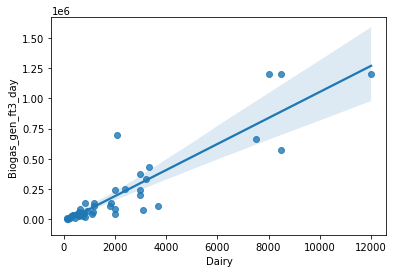

In [82]:
dairy_plugflow = pd.DataFrame(df6,columns=['Dairy', "Biogas_gen_ft3_day"])

sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_plugflow, ci = 95)
dairy_plugsum = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=dairy_plugflow).fit()
print(dairy_plugsum.summary())

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

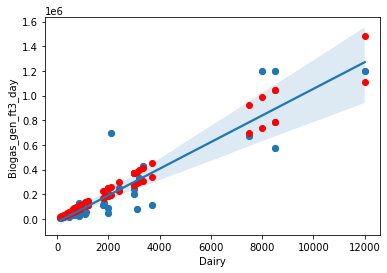

In [83]:
sns.regplot('Dairy', 'Biogas_gen_ft3_day', data=dairy_plugflow, ci = 95)

Y_upper_dairy_biogas_pf = dairy_plugflow['Dairy']*123.246+.000269
Y_lower_dairy_biogas_pf = dairy_plugflow['Dairy']*92.572-.000765

plt.scatter(dairy_plugflow['Dairy'], dairy_plugflow['Biogas_gen_ft3_day'])
plt.scatter(dairy_plugflow['Dairy'], Y_upper_dairy_biogas_pf, color = 'red')
plt.scatter(dairy_plugflow['Dairy'], Y_lower_dairy_biogas_pf, color = 'red')

plt.show

In [84]:
def filter_confidence_interval_pf(data):
    Y_upper = data['Dairy']*123.246+.000269
    Y_lower = data['Dairy']*92.572-.000765
    filtered_data = data[(data['Biogas_gen_ft3_day'] >= Y_lower) & (data['Biogas_gen_ft3_day'] <= Y_upper)]
    return filtered_data

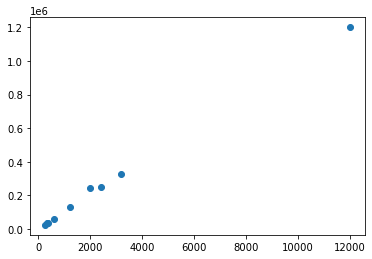

In [85]:
ci95dairy_biogas_pf = filter_confidence_interval_pf(dairy_plugflow)

plt.scatter(ci95dairy_biogas_pf['Dairy'], ci95dairy_biogas_pf['Biogas_gen_ft3_day'])

In [86]:
dairy_biogas4 = smf.ols(formula='Biogas_gen_ft3_day ~ Dairy', data=ci95dairy_biogas_pf).fit()
print(dairy_biogas4.summary())

                            OLS Regression Results                            
Dep. Variable:     Biogas_gen_ft3_day   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4873.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           3.26e-11
Time:                        16:13:12   Log-Likelihood:                -98.196
No. Observations:                   9   AIC:                             200.4
Df Residuals:                       7   BIC:                             200.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7996.2535   6143.898      1.301      0.2

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Swine Impermeable Cover Investigation

The data for the swine anaerobic digesters was very poor. I decided to only analyze impermeable cover digester type for swine as I felt the other digester types had too little data.

In [87]:
df7 = df.rename(columns={"Animal/Farm Type(s)" : "Animal", "Co-Digestion" : "Codigestion", "Biogas End Use(s)" : "Biogas_End_Use", " Biogas Generation Estimate (cu_ft/day) " : "Biogas_gen_ft3_day"})

In [88]:
df7.drop(df7[(df7['Animal'] != 'Swine')].index, inplace = True)
df7.drop(df7[(df7['Codigestion'] != 0)].index, inplace = True)
df7.drop(df7[(df7['Biogas_gen_ft3_day'] == 0)].index, inplace = True)
df7['Biogas_ft3/cow'] = df7['Biogas_gen_ft3_day'] / df7['Swine']

#df7.drop(df7[(df7['Biogas_End_Use'] == 0)].index, inplace = True)

#selecting for 'Covered Lagoon'

notwant = ['Mixed Plug Flow', 'Unknown or Unspecified',
       'Complete Mix', 'Horizontal Plug Flow', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor',
       'Vertical Plug Flow', 'Complete Mix Mini Digester',
       'Plug Flow - Unspecified', 'Dry Digester', 'Modular Plug Flow',
       'Microdigester']

df7 = df7[~df7['Digester Type'].isin(notwant)]

<AxesSubplot:xlabel='Biogas_ft3/cow', ylabel='Count'>

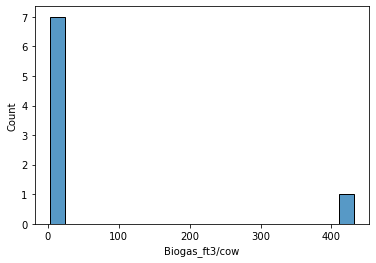

In [89]:
sns.histplot(data = df7['Biogas_ft3/cow'], bins = 20)

In [90]:
df7.shape

(8, 22)

In [91]:
ci95_df7 = hist_filter_ci(df7)

<AxesSubplot:xlabel='Biogas_ft3/cow', ylabel='Count'>

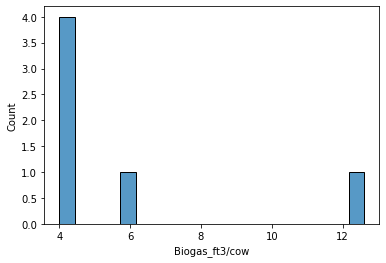

In [92]:
sns.histplot(data = ci95_df7['Biogas_ft3/cow'], bins = 20)

In [93]:
ci95_df7['Biogas_ft3/cow'].mean()
efficiency(ci95_df7['Biogas_ft3/cow'].mean())

5.725326735990197

Checking if there was some correlation between location and impermeable cover digester efficiency. There does not appear to be the desired correlation. 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Swine', ylabel='Biogas_gen_ft3_day'>

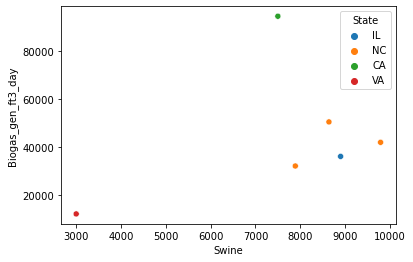

In [94]:
sns.scatterplot('Swine', 'Biogas_gen_ft3_day', data = ci95_df7, hue = 'State')

# Swine Impermeable Cover and Electricity Investigation

The next section investigates "Swine Impermeable Cover and Electricity Investigation" because there are a variety of swine digester data points where biogas production is not recorded, although electricity generation is recorded.

In [95]:
df8 = df.rename(columns={"Animal/Farm Type(s)" : "Animal", "Co-Digestion" : "Codigestion", "Biogas End Use(s)" : "Biogas_End_Use", " Biogas Generation Estimate (cu_ft/day) " : "Biogas_gen_ft3_day"})

In [96]:
df8.drop(df8[(df8['Animal'] != 'Swine')].index, inplace = True)
df8.drop(df8[(df8['Codigestion'] != 0)].index, inplace = True)
df8.drop(df8[(df8[' Electricity Generated (kWh/yr) '] == 0)].index, inplace = True)
df8['Elec/swine'] = df8[' Electricity Generated (kWh/yr) '] / df8['Swine']
df8.drop(df8[(df8['Swine'] > 20000)].index, inplace = True)
#df7.drop(df7[(df7['Biogas_End_Use'] == 0)].index, inplace = True)

#selecting for 'Covered Lagoon'

notwant = ['Mixed Plug Flow', 'Unknown or Unspecified',
       'Complete Mix', 'Horizontal Plug Flow', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor',
       'Vertical Plug Flow', 'Complete Mix Mini Digester',
       'Plug Flow - Unspecified', 'Dry Digester', 'Modular Plug Flow',
       'Microdigester']

df8 = df8[~df8['Digester Type'].isin(notwant)]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Swine', ylabel=' Electricity Generated (kWh/yr) '>

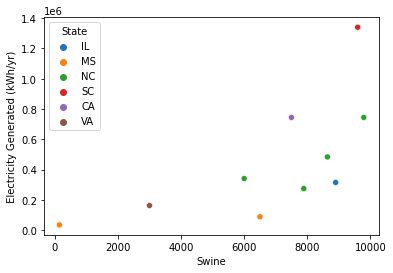

In [97]:
sns.scatterplot('Swine', ' Electricity Generated (kWh/yr) ', data = df8, hue = 'State')

# Naive Bayes Machine Learning- Predict Biogas Amount and Efficiency

Naive Bayes machine learning is completed in this section to predict the daily biogas production from an inputted number of dairy cows and an inputted digester type. Naive Bayes is a poor way to predict daily biogas production based on this data. Naive Bayes machine learns based on categories, not on a regression spectrum. For any input, Naive Bayes will output a biogas production value that corresponds to a value in the training dataset. This is not what I wanted, but I completed the analysis before I figured this out, so I have left it here.

In [98]:
df9 = df.rename(columns={"Animal/Farm Type(s)" : "Animal", "Co-Digestion" : "Codigestion", "Biogas End Use(s)" : "Biogas_End_Use", " Biogas Generation Estimate (cu_ft/day) " : "Biogas_gen_ft3_day"})

In [99]:
df9

,Project Name,Project Type,City,County,State,Digester Type,Status,Year Operational,Animal,Cattle,...,Poultry,Swine,Codigestion,Biogas_gen_ft3_day,Electricity Generated (kWh/yr),Biogas_End_Use,System Designer(s)_Developer(s) and Affiliates,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?
0,Cargill - Sandy River Farm Digester,Farm Scale,Morrilton,Conway,AR,Covered Lagoon,Operational,2008.0,Swine,0,...,0,4200,0,1814400,0,Flared Full-time,Martin Construction Resource LLC (formerly RCM...,0,"4,002",0
1,Butterfield RNG Digester,Farm Scale,Buckeye,Maricopa,AZ,Mixed Plug Flow,Construction,2021.0,Dairy,0,...,0,0,0,0,0,Pipeline Gas,"Avolta [Project Developer]; DVO, Inc. (formerl...",Southwest Gas,"29,826",Y
2,Caballero Dairy Farms Digester,Farm Scale,Eloy,Pinal,AZ,Unknown or Unspecified,Construction,2022.0,Dairy,0,...,0,0,0,0,0,Pipeline Gas,Brightmark [Project Developer],0,"89,518",0
3,Paloma Dairy Digester,Farm Scale,Gila Bend,Maricopa,AZ,Complete Mix,Operational,2021.0,Dairy,0,...,0,0,0,0,0,CNG,Black Bear Environmental Assets [Project Devel...,Southwest Gas Company,"89,794",0
4,Stotz Southern Dairy Digester,Farm Scale,Buckeye,Maricopa,AZ,Covered Lagoon,Operational,2011.0,Dairy,0,...,0,0,0,0,5256000,Electricity,Chapel Street Environmental [System Design Eng...,Arizona Public Service,"138,787",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Norswiss Farms Digester,Farm Scale,Rice Lake,Barron,WI,Complete Mix,Shut down,2006.0,Dairy,0,...,0,0,"Dairy Processing Wastes; Fats, Oils, Greases; ...",2908000,6450000,Electricity,"Microgy [Project Developer, System Designer]",Dairyland Power Cooperative; Barron Electric,0,Y
502,Quantum Dairy Digester,Farm Scale,Weyauwega,Waupaca,WI,Mixed Plug Flow,Shut down,2005.0,Dairy,0,...,0,0,0,0,3350700,Cogeneration,"DVO, Inc. (formerly GHD, Inc.) [Project Develo...","WE Energies, Inc.",0,Y
503,Stencil Farm Digester,Farm Scale,Denmark,Brown,WI,Horizontal Plug Flow,Shut down,2002.0,Dairy,0,...,0,0,0,0,946080,Electricity,Martin Construction Resource LLC (formerly RCM...,Wisconsin Public Service Corporation,0,0
504,Tinedale Farms Digester,Farm Scale,Wrightstown,Jackson,WI,Fixed Film/Attached Media,Shut down,1999.0,Dairy,0,...,0,0,0,200000,5584500,Electricity; Boiler/Furnace fuel,"AGES [Project Developer, System Designer, Syst...",0,0,0


In [100]:
df9.columns

Index(['Project Name', 'Project Type', 'City', 'County', 'State',
       'Digester Type', 'Status', 'Year Operational', 'Animal', 'Cattle',
       'Dairy', 'Poultry', 'Swine', 'Codigestion', 'Biogas_gen_ft3_day',
       ' Electricity Generated (kWh/yr) ', 'Biogas_End_Use',
       'System Designer(s)_Developer(s) and Affiliates', 'Receiving Utility',
       ' Total Emission Reductions (MTCO2e/yr) ', 'Awarded USDA Funding?'],
      dtype='object')

In [101]:
df.bayes = df9[["Digester Type","Dairy","Biogas_gen_ft3_day"]].copy()

C:\Users\lcsoko\AppData\Local\Temp\ipykernel_12912\3026402764.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.bayes = df9[["Digester Type","Dairy","Biogas_gen_ft3_day"]].copy()


In [102]:
df.bayes["Digester Type"].unique()

array(['Covered Lagoon', 'Mixed Plug Flow', 'Unknown or Unspecified',
       'Complete Mix', 'Horizontal Plug Flow', 0,
       'Fixed Film/Attached Media',
       'Primary digester tank with secondary covered lagoon',
       'Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor',
       'Vertical Plug Flow', 'Complete Mix Mini Digester',
       'Plug Flow - Unspecified', 'Dry Digester', 'Modular Plug Flow',
       'Microdigester'], dtype=object)

In [103]:
#I want 'Covered Lagoon', 'Mixed Plug Flow','Complete Mix','Horizontal Plug Flow','Vertical Plug Flow','Plug Flow - Unspecified'

notwant = ['Unknown or Unspecified', 0,'Fixed Film/Attached Media','Primary digester tank with secondary covered lagoon','Induced Blanket Reactor', 'Anaerobic Sequencing Batch Reactor', 'Complete Mix Mini Digester','Dry Digester', 'Modular Plug Flow','Microdigester']

df.bayes = df.bayes[~df.bayes['Digester Type'].isin(notwant)]
df.bayes.drop(df.bayes[(df.bayes['Biogas_gen_ft3_day'] == 0)].index, inplace = True)
df.bayes.drop(df.bayes[(df.bayes['Dairy'] == 0)].index, inplace = True)

C:\Users\lcsoko\AppData\Local\Temp\ipykernel_12912\1780971751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bayes.drop(df.bayes[(df.bayes['Biogas_gen_ft3_day'] == 0)].index, inplace = True)
C:\Users\lcsoko\AppData\Local\Temp\ipykernel_12912\1780971751.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bayes.drop(df.bayes[(df.bayes['Dairy'] == 0)].index, inplace = True)


In [213]:
df.bayes

,Digester Type,Dairy,Biogas_gen_ft3_day,biogas/dairy
0,1,15500,600000,38.709677
1,1,1700,50000,29.411765
2,1,9700,270000,27.835052
3,1,7000,360000,51.428571
4,1,400,30000,75.000000
...,...,...,...,...
108,3,10000,2739726,273.972600
109,2,455,14000,30.769231
110,2,380,37500,98.684211
111,3,350,33450,95.571429


In [214]:
df.bayes=df.bayes.reset_index(drop=True)


To simplify the machine learning, I number coded the anaerobic digester types where 1 = covered lagoon, 2 = plug flow, and 3 = complete mix. Machine learning wizards may bully me for this, but I am a mere machine learning novice.

In [215]:
df.bayes["Digester Type"].replace('Covered Lagoon',1, inplace = True)
df.bayes["Digester Type"].replace('Mixed Plug Flow',2, inplace =True)
df.bayes["Digester Type"].replace('Horizontal Plug Flow',2, inplace = True)
df.bayes["Digester Type"].replace('Vertical Plug Flow',2, inplace = True)
df.bayes["Digester Type"].replace('Plug Flow - Unspecified',2,inplace = True)
df.bayes["Digester Type"].replace('Complete Mix',3,inplace = True)

In [216]:
df.bayes

,Digester Type,Dairy,Biogas_gen_ft3_day,biogas/dairy
0,1,15500,600000,38.709677
1,1,1700,50000,29.411765
2,1,9700,270000,27.835052
3,1,7000,360000,51.428571
4,1,400,30000,75.000000
...,...,...,...,...
108,3,10000,2739726,273.972600
109,2,455,14000,30.769231
110,2,380,37500,98.684211
111,3,350,33450,95.571429


In [217]:
df.bayes['biogas/dairy'] = df.bayes['Biogas_gen_ft3_day']/df.bayes['Dairy']

There are a couple outlandish biogas/dairy values. I filter the data so all data machine learned has biogas/dairy values within 2 standard deviations.

In [218]:
def pred_filter(data):
    Y_upper = np.percentile(data['biogas/dairy'], 97.5)
    Y_lower = np.percentile(data['biogas/dairy'], 2.5)
    filtered_hist_data = data[(data['biogas/dairy'] >= Y_lower) & (data['biogas/dairy'] <= Y_upper)]
    return filtered_hist_data

In [219]:
pred_filter(df.bayes)

,Digester Type,Dairy,Biogas_gen_ft3_day,biogas/dairy
0,1,15500,600000,38.709677
1,1,1700,50000,29.411765
2,1,9700,270000,27.835052
3,1,7000,360000,51.428571
4,1,400,30000,75.000000
...,...,...,...,...
107,1,980,47000,47.959184
108,3,10000,2739726,273.972600
109,2,455,14000,30.769231
110,2,380,37500,98.684211


In [220]:
df_bayes_clean = pred_filter(df.bayes).drop(columns=['biogas/dairy'])

In [221]:
df_bayes_clean

,Digester Type,Dairy,Biogas_gen_ft3_day
0,1,15500,600000
1,1,1700,50000
2,1,9700,270000
3,1,7000,360000
4,1,400,30000
...,...,...,...
107,1,980,47000
108,3,10000,2739726
109,2,455,14000
110,2,380,37500


In [222]:
X1 = df_bayes_clean.drop(["Biogas_gen_ft3_day"], axis = 1)
Y1 = df_bayes_clean["Biogas_gen_ft3_day"]

In [223]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, random_state = 1)

In [224]:
x_train1 = np.array(x_train1)
y_train1 = np.array(y_train1).squeeze()

In [225]:
nb.fit(x_train1, y_train1)

MultinomialNB()

In [226]:
y_predicted = nb.predict(x_test1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


In [227]:
accuracy_score(y_test1, y_predicted)

0.037037037037037035

In [228]:
nb.predict([[2,500]])

array([132000])

In [229]:
mean_squared_error(y_test1, y_predicted, squared = False)

11778.084345590833

In [230]:
def biogas_pred_nb(digester_type,dairy):
    biogas = nb.predict([[digester_type,dairy]])
    dairy_eff = nb.predict([[digester_type,dairy]])/dairy/101.336
    return biogas, dairy_eff

Predicting ft3 biogas/day (output 1) and digester efficiency (output 2) using Naive Bayes machine learning where input 1 is digester type (1 is impermeable cover, 2 is plug flow, 3 is complete mix) and input 2 is number of dairy

In [290]:
biogas_pred_nb(2,5000)

(array([1200000]), array([2.36835873]))

In [291]:
biogas_pred_nb(1,5000)

(array([1200000]), array([2.36835873]))

In [292]:
biogas_pred_nb(3,5000)

(array([432000]), array([0.85260914]))

# Random Forest


Random forest machine learning is completed in this section to predict the daily biogas production from an inputted number of dairy cows and an inputted digester type. 

In [234]:
df_forest_clean = df_bayes_clean

In [235]:
df_forest_clean

,Digester Type,Dairy,Biogas_gen_ft3_day
0,1,15500,600000
1,1,1700,50000
2,1,9700,270000
3,1,7000,360000
4,1,400,30000
...,...,...,...
107,1,980,47000
108,3,10000,2739726
109,2,455,14000
110,2,380,37500


In [236]:
X = df_forest_clean.drop(["Biogas_gen_ft3_day"], axis = 1)
y = df_forest_clean["Biogas_gen_ft3_day"]

In [237]:
from sklearn.model_selection import train_test_split
import sklearn.ensemble as ske

In [238]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [239]:
reg = ske.RandomForestRegressor(n_estimators = 1000, random_state = 0)

In [240]:
Y_train = np.ravel(Y_train)

In [241]:
reg.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=1000, random_state=0)

In [242]:
Y_pred = reg.predict(X_test)

In [243]:
from sklearn.metrics import explained_variance_score,max_error, mean_absolute_error, mean_squared_error, r2_score

In [244]:
mean_squared_error(Y_test, Y_pred, squared = False)

277429.45213811955

In [245]:
explained_variance_score(Y_test, Y_pred)

-0.1536456579754666

In [246]:
max_error(Y_test, Y_pred)

1253062.108

In [247]:
reg.predict([[2,500]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([28353.144])

In [248]:
def biogas_pred_rf(digester_type,dairy):
    biogas = reg.predict([[digester_type,dairy]])
    dairy_eff = reg.predict([[digester_type,dairy]])/dairy/101.336
    return biogas, dairy_eff

Below are the random forest predictions for daily biogas production in ft3/day and efficiency (as a fraction, not percentage) for 5000 dairy cows for plug flow, then impermeable cover, then complete mixed anaerobic digester types. The random forest predictions are significantly better than the Naive Bayes predictions as noted by efficiency values that are less than 1.

In [287]:
biogas_pred_rf(2,5000)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([352650.592]), array([0.69600259]))

In [288]:
biogas_pred_rf(1,5000)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([270734.848]), array([0.53433103]))

In [289]:
biogas_pred_rf(3,5000)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([325077.044]), array([0.64158255]))

Using the AgSTAR anaerobic digester database, this notebook calculates digester efficiencies for dairy manure (all types) digesters, dairy manure plug flow digesters, dairy manure complete mix digesters, and dairy manure impermeable cover digesters. This notebook also features linear regression analysis and 95% confidence intervals for all aforementioned digester types, where the independent variable is the number of dairy cows and the dependent variable is daily biogas production.

Efficiencies of Digesters using 95% CI (2 standard deviation) are:

Dairy- all anaerobic digester types: 68.8%

Dairy plug flow: 73.7%

Dairy complete mix: 85.9%

Dairy impermeable cover: 43.1%

Efficiencies of Digesters using 68% CI (1 standard deviation) are:

Dairy- all anaerobic digester types: 65.8%

Dairy plug flow: 71.3%

Dairy complete mix: 82.7%

Dairy impermeable cover: 41.1%

Digester efficiencies for swine manure anaerobic digesters were not analyzed due to little and poor data.

This notebook also features graphs relating impermeable cover digester daily biogas production to number of dairy or swine and location. Impermeable cover digesters are not heated, and therefore digestion efficiency should be heavily influenced by outdoor temperature. Based on the visuals of the graphs, there seems to be an insufficient amount of data and no correlation between greater biogas production per animal and southern states. This conclusion seems unlikely. With more data, we should see biogas production per animal influenced by the geographical location of the digester.

Naive Bayes and Random Forest machine learning methods were used to predict daily biogas productions for dairy digesters given the number of dairy cows and type of digester. Daily biogas production should be approximately linearly related to the number of dairy cows, meaning the model should behave as a regression model. Naive Bayes machine learns uses categorization, and categorization is discrete, or not continuous like a regression model. Therefore, Naive Bayes is a poor machine learning method for this application. Random Forest machine learning can effectively model a continuous regression model. The random forest efficiency prediction are significantly closer the efficiency values calculated using the confidence intervals.

Naive Bayes daily biogas and digester efficiency prediction for 5000 dairy cows:

Plug flow: 1,200,000 ft3 biogas/day     236.8% efficient

Complete mix: 432,000 ft3 biogas/day     85.3% efficient

Impermeable cover: 1,200,000 ft3 biogas/day     236.6% efficient


Random Forest daily biogas and digester efficiency prediction for 5000 dairy cows:

Plug flow: 352,651 ft3 biogas/day     69.6% efficient

Complete mix: 325,077 ft3 biogas/day     64.2% efficient

Impermeable cover: 270,735 ft3 biogas/day   53.4% efficient

Overall, digester efficiencies appear to be similar to that reported in literature. Nonetheless, more data would vastly improve anaerobic digestion efficiency analysis and the Random Forest model which predicts daily biogas production.
